$\color{yellow}{\text{Importy niezbędnych bibliotek}}$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

$\color{yellow}{\text{Zadanie 1}}$

Definiujemy sieć w PyTorch

In [4]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        return self.fce(x)

Zadajemy funkcje kosztu:
* rezydulanego
* związanego z warunkiem początkowym
* całościowego

In [14]:
def residual_loss(model, x, omega):
    x.requires_grad_(True)
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True)[0]
    return torch.mean((u_x - torch.cos(omega * x))**2)

def initial_condition_loss(model):
    u_0 = model(torch.tensor([[0.0]], dtype=torch.float32))
    return torch.mean((u_0 - 0.0)**2)

def total_loss(model, x, omega):
    return residual_loss(model, x, omega) + initial_condition_loss(model)

Funkcja trenująca model

In [15]:
def train_model(omega, x_train, N_HIDDEN, N_LAYERS, epochs=50000, learning_rate=0.001):
    model = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=N_HIDDEN, N_LAYERS=N_LAYERS)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, x_train, omega)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return model, loss_history

Funkcja przedstawiająca wyniki

In [18]:
def plot_results(model, omega, x_test, loss_history):
    def exact_solution(x, omega):
        return np.sin(omega * x) / omega

    # Obliczanie rozwiązania analitycznego
    x_test_np = x_test.detach().numpy()  # Odłączenie tensorów i konwersja do numpy
    u_exact = exact_solution(x_test_np, omega)
    
    # Obliczanie przewidywanego rozwiązania przez model
    u_pred = model(x_test).detach().numpy()

    # Obliczanie funkcji błędu
    error = np.abs(u_exact - u_pred)

    # Tworzenie wykresów
    plt.figure(figsize=(18, 6))

    # Wykres porównujący dokładne rozwiązanie z przewidywanym rozwiązaniem
    plt.subplot(1, 3, 1)
    plt.plot(x_test_np, u_exact, 'b-', label='Rozwiązanie analityczne $u(x)$')
    plt.plot(x_test_np, u_pred, 'r--', label=r'Przewidywane rozwiązanie $\hat{u}(x)$')
    plt.legend()
    plt.title(f'Porównanie otrzymanego rozwiązania z analitycznym dla ω={omega}')
    plt.xlabel('x')
    plt.ylabel('u(x)')

    # Wykres funkcji błędu
    plt.subplot(1, 3, 2)
    plt.plot(x_test_np, error, 'g-', label='Błąd $|u(x) - \hat{u}(x)|$')
    plt.legend()
    plt.title('Wykres funkcji błędu')
    plt.xlabel('x')
    plt.ylabel('Błąd')

    # Wykres funkcji kosztu
    plt.subplot(1, 3, 3)
    plt.plot(loss_history, 'k-')
    plt.title('Wykres funkcji kosztu')
    plt.xlabel('Epoka')
    plt.ylabel('Koszt')

    plt.tight_layout()
    plt.show()

Funkcja porównująca wyniki dwóch modeli na wspólnym wykresie

In [12]:
def compare_results(model_a, model_b, omega, x_test, loss_history_a, loss_history_b):
    def exact_solution(x, omega):
        return np.sin(omega * x) / omega

    # Obliczanie rozwiązania analitycznego
    x_test_np = x_test.detach().numpy()  # Odłączenie tensorów i konwersja do numpy
    u_exact = exact_solution(x_test_np, omega)
    
    # Obliczanie przewidywanego rozwiązania przez modele
    u_pred_standard = model_a(x_test).detach().numpy()
    u_pred_ansatz = model_b(x_test).detach().numpy()

    # Obliczanie funkcji błędu
    error_a = np.abs(u_exact - u_pred_standard)
    error_b = np.abs(u_exact - u_pred_ansatz)

    # Tworzenie wykresów
    plt.figure(figsize=(18, 6))

    # Wykres porównujący dokładne rozwiązanie z przewidywanym rozwiązaniem
    plt.subplot(1, 3, 1)
    plt.plot(x_test_np, u_exact, 'b-', label='Rozwiązanie analityczne $u(x)$')
    plt.plot(x_test_np, u_pred_standard, 'r--', label=r'Przewidywane rozwiązanie (standard) $\hat{u}(x)$')
    plt.plot(x_test_np, u_pred_ansatz, 'g--', label=r'Przewidywane rozwiązanie (ansatz) $\hat{u}(x)$')
    plt.legend()
    plt.title(f'Porównanie otrzymanego rozwiązania z analitycznym dla $\omega={omega}$')
    plt.xlabel('x')
    plt.ylabel('u(x)')

    # Wykres funkcji błędu
    plt.subplot(1, 3, 2)
    plt.plot(x_test_np, error_a, 'r-', label='Błąd (standard) $|u(x) - \hat{u}(x)|$')
    plt.plot(x_test_np, error_b, 'g-', label='Błąd (ansatz) $|u(x) - \hat{u}(x)|$')
    plt.legend()
    plt.title('Wykres funkcji błędu')
    plt.xlabel('x')
    plt.ylabel('Błąd')

    # Wykres funkcji kosztu
    plt.subplot(1, 3, 3)
    plt.plot(loss_history_a, 'r-', label='Koszt (standard)')
    plt.plot(loss_history_b, 'g-', label='Koszt (ansatz)')
    plt.legend()
    plt.title('Wykres funkcji kosztu')
    plt.xlabel('Epoka')
    plt.ylabel('Koszt')

    plt.tight_layout()
    plt.show()

```Podpunkt a```

Trening

In [16]:
x_train_200 = torch.linspace(-2*np.pi, 2*np.pi, 200).view(-1, 1).float() # 200 punktow pomiedzy -2pi a 2pi
x_test_1000 = torch.linspace(-2*np.pi, 2*np.pi, 1000).view(-1, 1).float() # 1000 punktow pomiedzy -2pi a 2pi
model_a, loss_history_a = train_model(omega=1, x_train=x_train_200, N_HIDDEN=16, N_LAYERS=2, epochs=50000)

Wyniki

In [19]:
plot_results(model_a, omega=1, x_test=x_test_1000, loss_history=loss_history_a)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

```Podpunkt b```

Trening

In [9]:
x_train_3000 = torch.linspace(-2*np.pi, 2*np.pi, 3000).view(-1, 1).float() # 200 punktow pomiedzy -2pi a 2pi
x_test_5000 = torch.linspace(-2*np.pi, 2*np.pi, 5000).view(-1, 1).float() # 5000 punktow pomiedzy -2pi a 2pi

2 warstwy ukryte, 16 neuronów w każdej

In [10]:
model_2_16, loss_history_2_16 = train_model(omega=15, x_train=x_train_3000, N_HIDDEN=16, N_LAYERS=2, epochs=50000)

4 warstwy ukryte, 64 neurony w każdej

In [11]:
model_4_64, loss_history_4_64 = train_model(omega=15, x_train=x_train_3000, N_HIDDEN=64, N_LAYERS=4, epochs=50000)

5 warstw ukrytych, 128 neuronów w każdej warstwie

In [12]:
model_5_128, loss_history_5_128 = train_model(omega=15, x_train=x_train_3000, N_HIDDEN=128, N_LAYERS=5, epochs=50000)

Wyniki

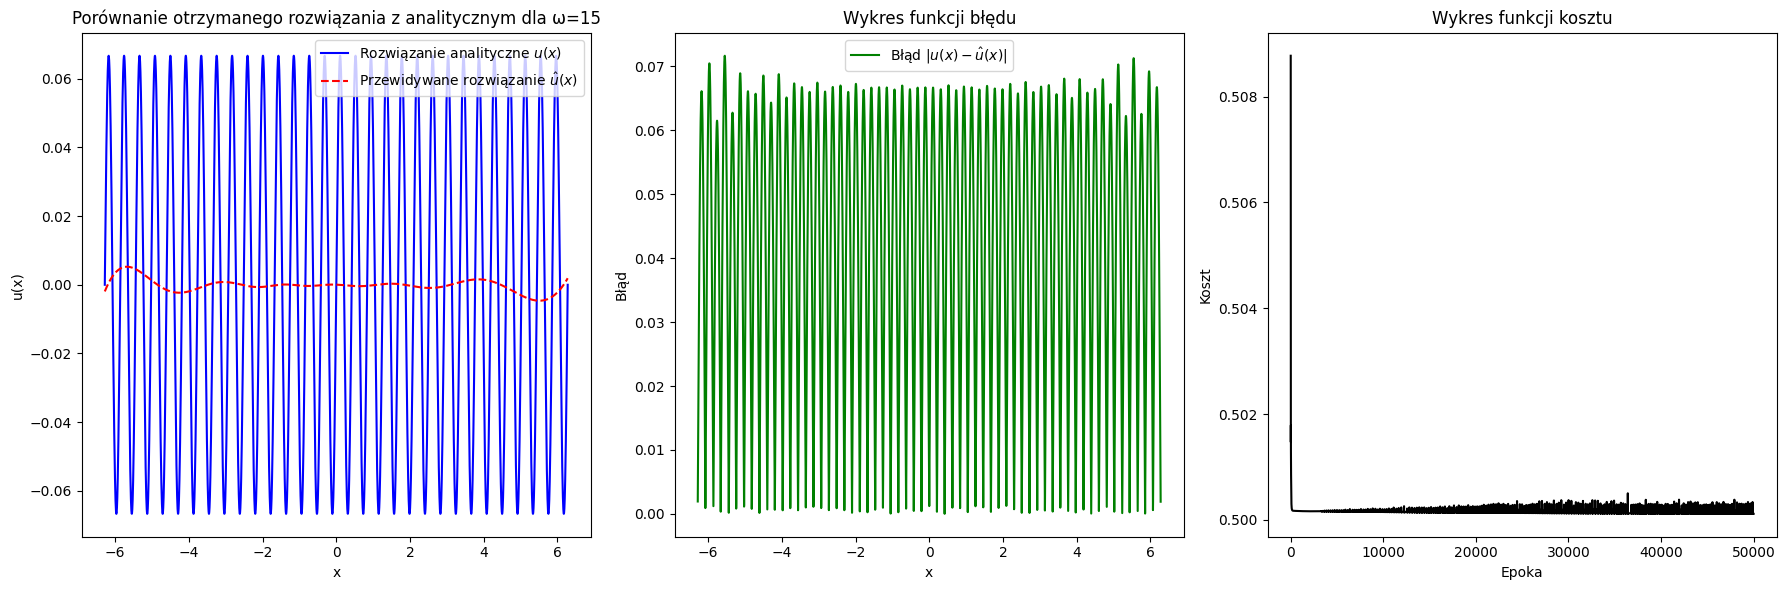

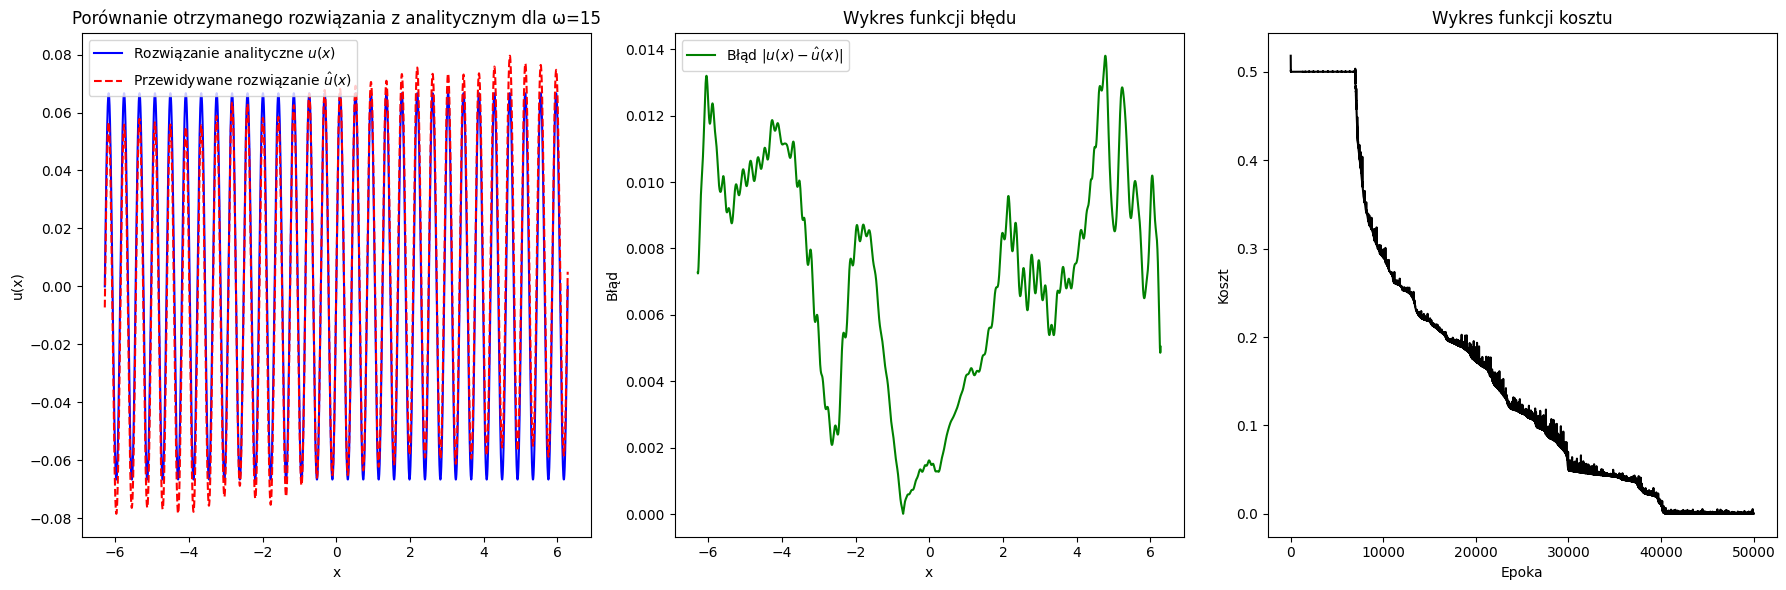

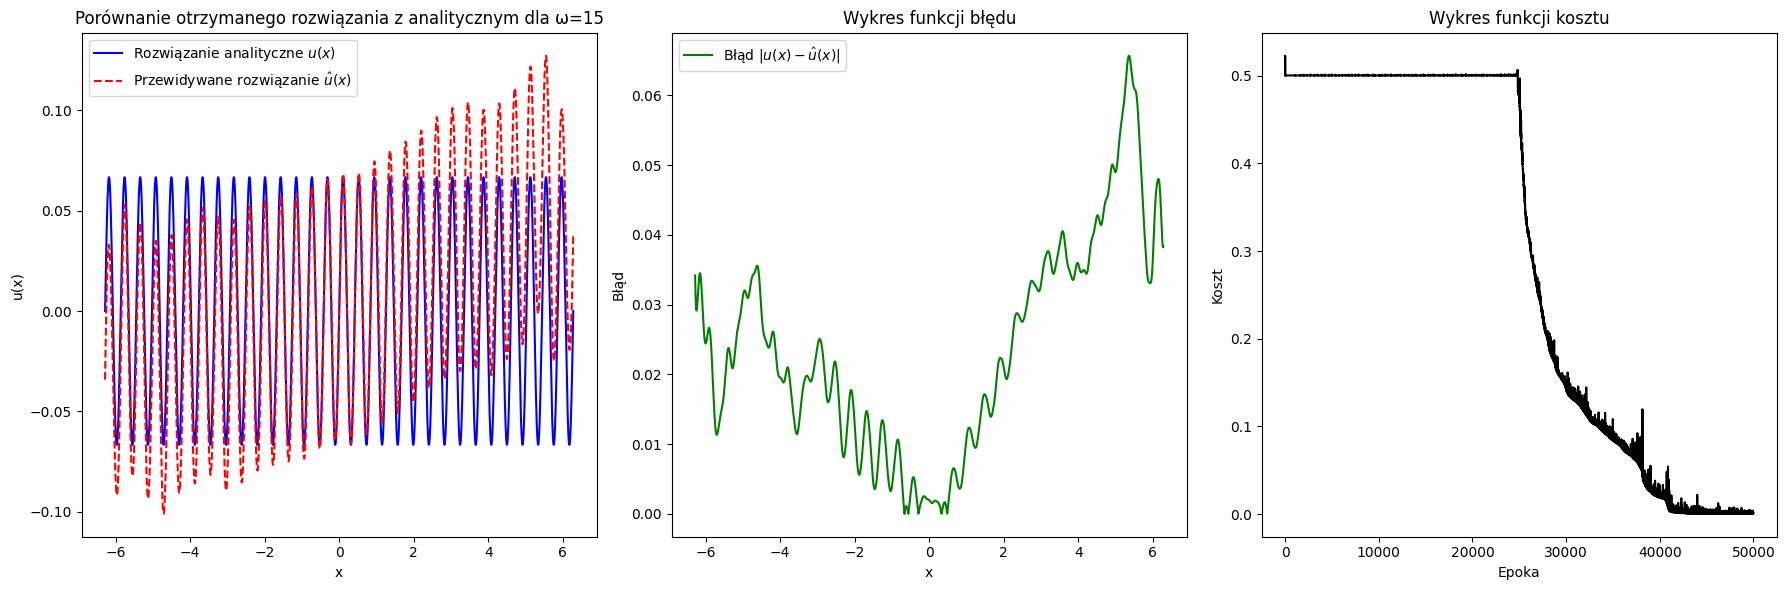

In [13]:
plot_results(model_2_16, omega=15, x_test=x_test_5000, loss_history=loss_history_2_16)
plot_results(model_4_64, omega=15, x_test=x_test_5000, loss_history=loss_history_4_64)
plot_results(model_5_128, omega=15, x_test=x_test_5000, loss_history=loss_history_5_128)

```Podpunkt c```

Model ansatz

In [14]:
class FCN_Ansatz(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, omega):
        super(FCN_Ansatz, self).__init__()
        self.omega = omega
        self.model = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

    def forward(self, x):
        return torch.tanh(self.omega * x) * self.model(x)

In [15]:
def total_loss_ansatz(model, x, omega): # Funkcja straty dla modelu z ansatzem
    return residual_loss(model, x, omega)

def train_model_ansatz(omega, x_train, N_HIDDEN, N_LAYERS, epochs=50000, learning_rate=0.001):
    model = FCN_Ansatz(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=N_HIDDEN, N_LAYERS=N_LAYERS, omega=omega)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss_ansatz(model, x_train, omega)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return model, loss_history

In [16]:
model_ansatz, loss_history_ansatz = train_model_ansatz(omega=15, x_train=x_train_3000, N_HIDDEN=64, N_LAYERS=4, epochs=50000)

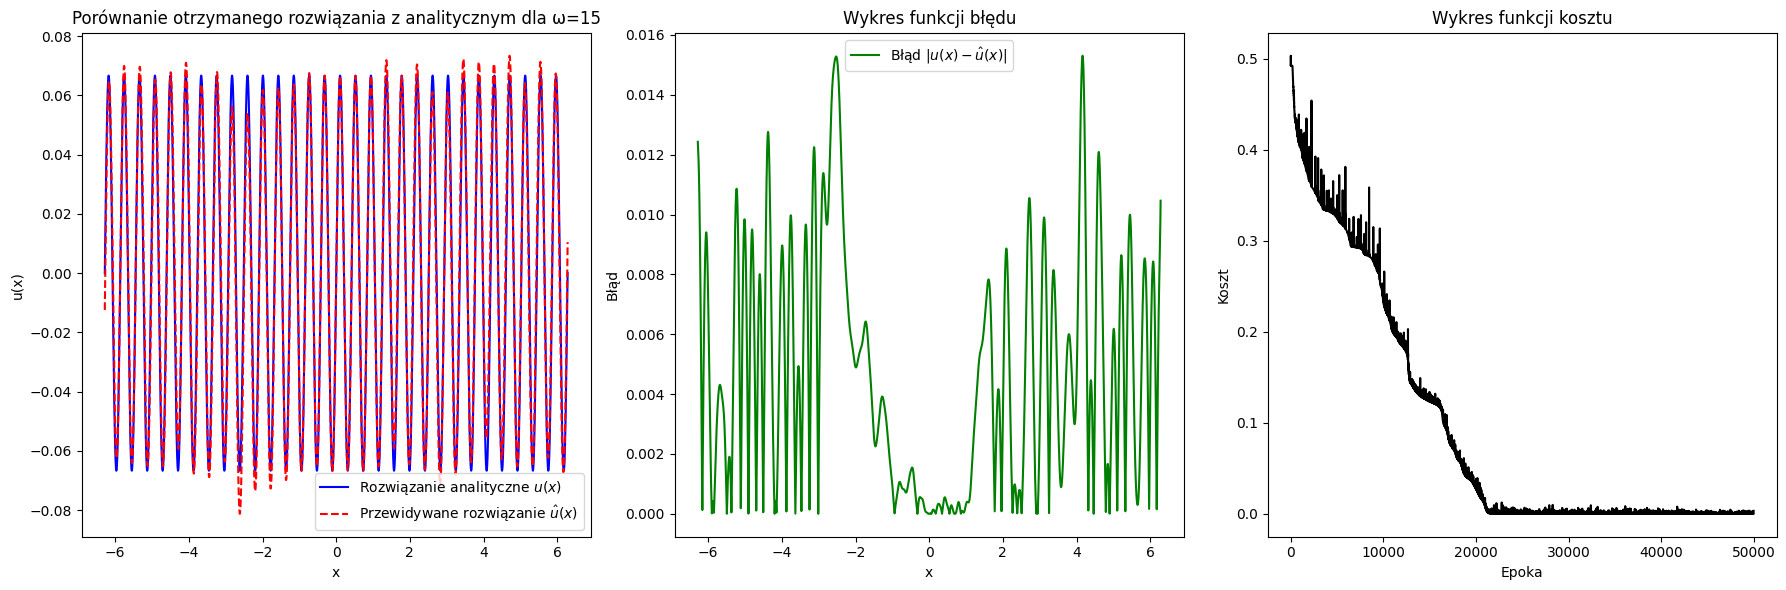

In [17]:
plot_results(model_ansatz, omega=15, x_test=x_test_5000, loss_history=loss_history_ansatz)

Porównanie wyników

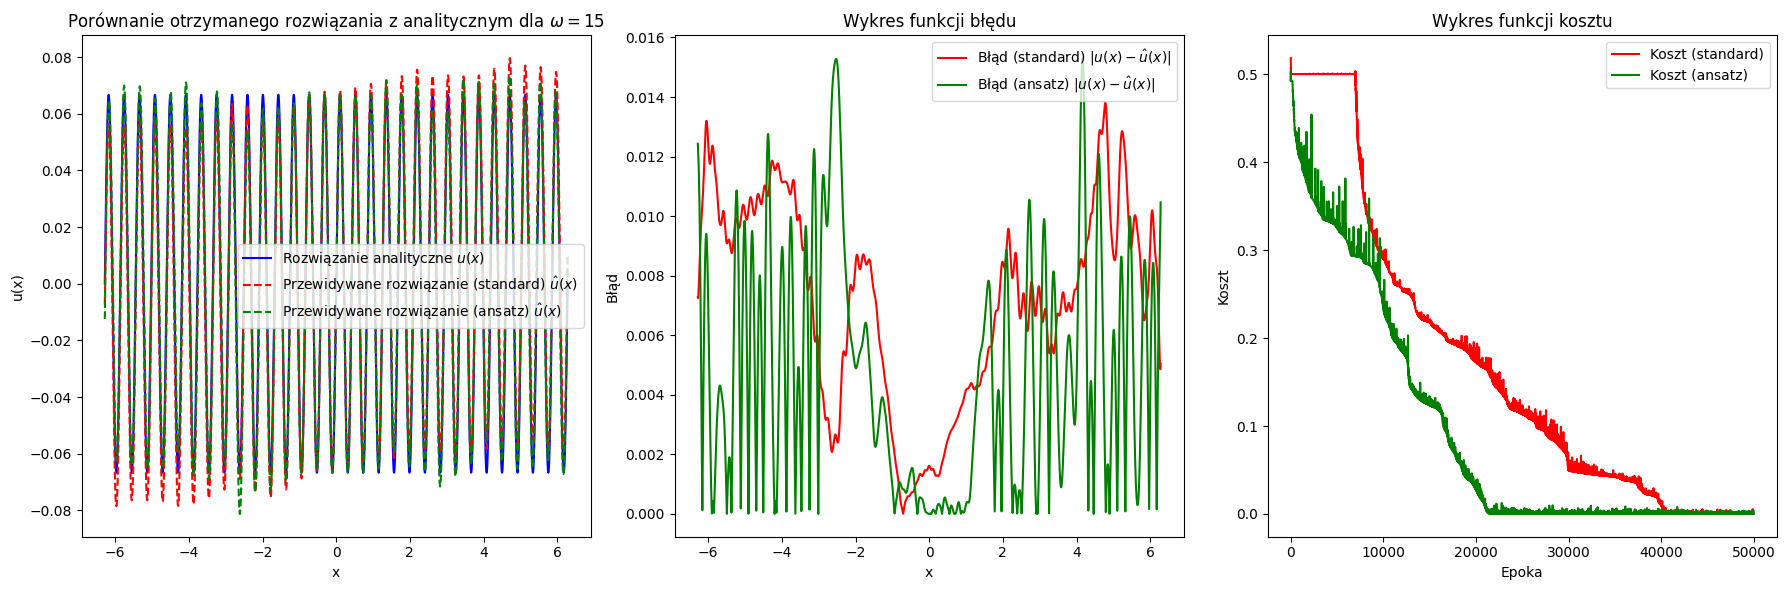

In [20]:
compare_results(model_4_64, model_ansatz, omega=15, x_test=x_test_5000, loss_history_a=loss_history_4_64, loss_history_b=loss_history_ansatz)

```Podpunkt d```

Model Fouriera

In [21]:
class FCN_Fourier(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN_Fourier, self).__init__()
        self.L = N_HIDDEN // 2
        self.N_HIDDEN = N_HIDDEN
        activation = nn.Tanh

        self.fcs = nn.Sequential(  # First layer
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        
        # First hidden layer with Fourier features
        self.fc_fourier = nn.Linear(2 * L * N_HIDDEN, N_HIDDEN)
        
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fourier_features(x)
        x = self.fc_fourier(x)
        x = self.fch(x)
        return self.fce(x)
    
    def fourier_features(self, x):
        # Apply Fourier features
        features = [torch.sin((2**i) * np.pi * x) for i in range(self.L)] + \
                   [torch.cos((2**i) * np.pi * x) for i in range(self.L)]
        return torch.cat(features, dim=-1)

In [24]:
model_fourier, loss_history_fourier = train_model(omega=15, x_train=x_train_3000, N_HIDDEN=64, N_LAYERS=4, epochs=50000)

Wyniki

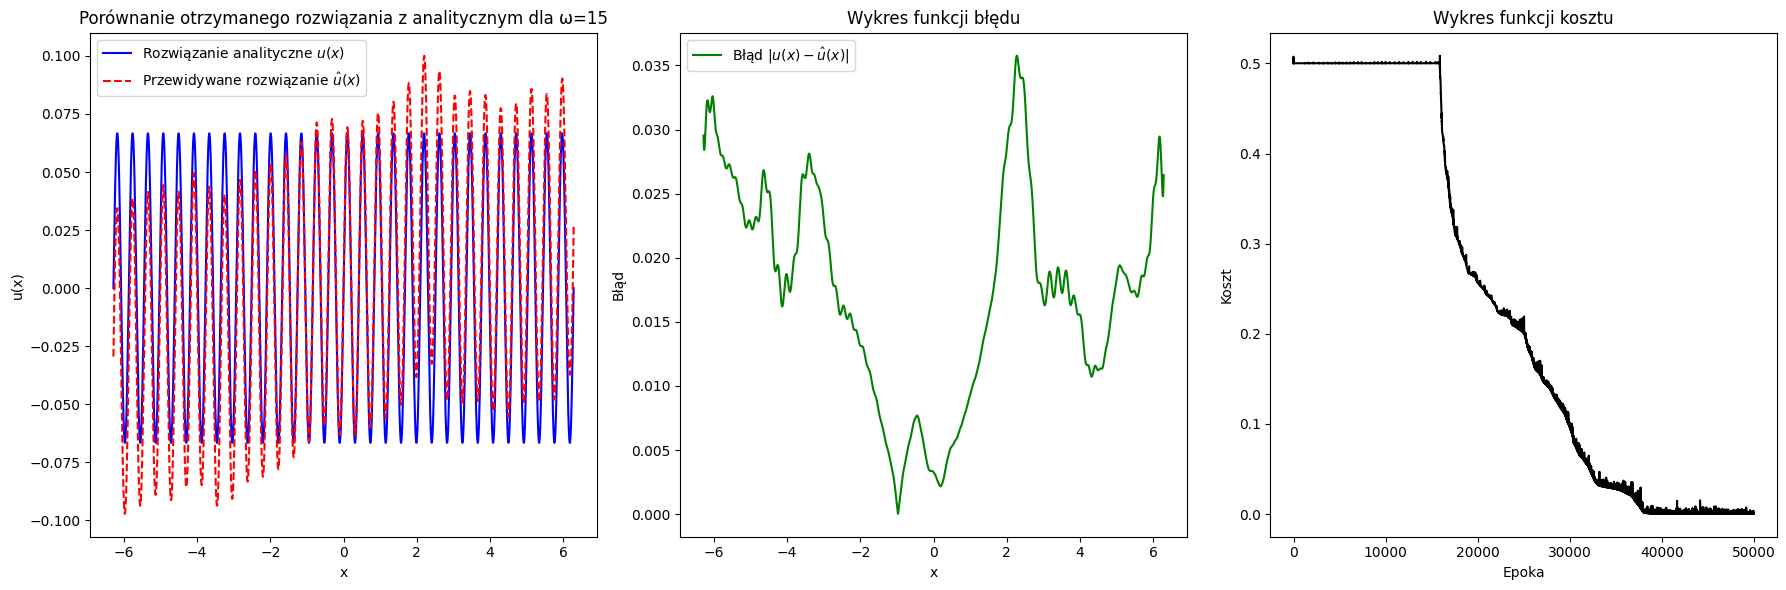

In [25]:
plot_results(model_fourier, omega=15, x_test=x_test_5000, loss_history=loss_history_fourier)